<a href="https://colab.research.google.com/github/gianclbal/ml_microbiome_based_cancer_prediction/blob/master/02_one_vs_all_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Experiment 1: One vs All Classification**

## ***Objectives for this Notebook***
* Showcase One vs All classification, train/test/validation split, cross validation, and GridSearchCV

**One vs All Classification (OvA)**, also known as One-vs-Rest (OvR), is a strategy used in machine learning for multi-class classification problems. In a multi-class classification task, there are more than two possible classes or categories that a given input can belong to. The goal of OvA is to extend binary classification algorithms to handle multi-class scenarios.

Here's a brief explanation of the One-vs-All strategy:

1. **Binary Classification for Each Class**: For each unique class in the multi-class problem, a binary classifier is trained. This means that if there are k classes, you will train k binary classifiers.

2. **Training Process**: For a specific class, the samples belonging to that class are considered as the positive class, and all other samples from other classes are considered as the negative class.
The binary classifier is trained to distinguish between the samples of the current class and the samples from all other classes.

3. **Decision Making**: During the prediction phase, each binary classifier makes a prediction, and the class associated with the classifier that outputs the highest confidence is chosen as the final prediction.

This way, the problem of multi-class classification is transformed into multiple independent binary classification sub-problems. The following is our setup for this experiment:
* **Head and neck cancer (HNSC) vs All**
* **Stomach cancer (STAD) vs All**
* **Colon cancer (COAD) vs All**
* **Esophageal cancer (ESCA) vs All**
* **Rectal cancer (READ) vs All**


## **1.) Loading the dataset and setting parameters**

In [ ]:
import pandas as pd
import numpy as np
import os

# Training
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

# Evaluation
import matplotlib.pyplot as plt
from sklearn.metrics import make_scorer, balanced_accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report

import random
from sklearn.utils import check_random_state

seed_value = 42

# Set Python seed
random.seed(seed_value)

# Set NumPy seed
np.random.seed(seed_value)

# Set scikit-learn seed
sklearn_random_state = check_random_state(seed_value)

In [ ]:
# If running colab:
from google.colab import drive
drive.mount('/content/drive')

# Navigate to where you saved the file from notebook 1, this is where I saved mine
microbiome_df = pd.read_csv("/content/drive/MyDrive/microbiome_dataset/microbiome_preprocessed_files/microbiome_merged_dfs.csv")

In [ ]:
microbiome_df = pd.read_csv("./dataset/microbiome_preprocessed_files/microbiome_merged_dfs.csv")

In [ ]:
print(microbiome_df.shape)
microbiome_df.head()

(512, 133)


,SampleID,Simonsiella,Treponema,Campylobacter,Helicobacter,Paracoccus,Comamonas,Pseudomonas,Xanthomonas,Agrobacterium,...,Hungatella,Pseudopropionibacterium,Peptoanaerobacter,Emergencia,Prevotellamassilia,Criibacterium,Fournierella,Negativibacillus,Duodenibacillus,label
0,TCGA-CG-5720-01A,0.0,0.0,0.000000,0.895050,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,STAD
1,TCGA-CN-4741-01A,0.0,0.0,0.010470,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,HNSC
2,TCGA-BR-6801-01A,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,STAD
3,TCGA-IG-A3I8-01A,0.0,0.0,0.000000,0.067717,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,ESCA
4,TCGA-L5-A4OT-01A,0.0,0.0,0.012202,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,ESCA


## **2.) Creating a data slicer**

We will create our own data slicer that will fetch the relevant data from our dataframe.

For experiment 1 using OvA, since we 5 classes, we will have 5 binary classifiers. Because we have 5 binary classifiers, we will need also need 5 datasets. For each dataset, we have a different cancer class that is targeted (positive class) and the samples from the remaining classes were grouped together into one major class (negative class), to make a binary classification problem.

The data slicer takes in the data we processed from the first notebook, and outputs a dictionary of datasets for experiment 1.


In [ ]:
classes = ["HNSC", "STAD", "COAD", "ESCA", "READ"]

In [ ]:
# Show the counts for each class in the df
microbiome_df["label"].value_counts()

label
HNSC    155
STAD    127
COAD    125
ESCA     60
READ     45
Name: count, dtype: int64

In [ ]:
def exp_1_data_slicer(dataframe, label_column, classes, train_test=True):
    """
    Generate a one-vs-all dataset for a specific class for experiment 1

    Parameters:
    - dataframe: pd.DataFrame, the input DataFrame.
    - label_column: str, the column name representing the labels.
    - classes: list, the classes.

    Returns:
    - dataset_dict: a dictionary where the keys is the targeted class and the values are its corresponding features and labels
    """

    dataset_dict = {}

    for i in classes:
        positive_class = i
        dframe = dataframe.copy()
        dframe['label'] = [1 if x == positive_class else 0 for x in dataframe[label_column]]
        print(i)
        print(dframe.label.value_counts())
        X = dframe.drop(["SampleID", "label"], axis=1)
        y = dframe["label"]
        if train_test:
            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, stratify=y, random_state=seed_value)
            dataset_dict[positive_class] = {"train": (X_train, y_train),
                                            "test": (X_test, y_test)}
        else:
            dataset_dict[positive_class] = {"feature": X,
                                            "label": y}

    return dataset_dict

In [ ]:
# Show the distribution per each class
exp1_datasets = exp_1_data_slicer(microbiome_df, "label", classes, train_test=True)

HNSC
label
0    357
1    155
Name: count, dtype: int64
STAD
label
0    385
1    127
Name: count, dtype: int64
COAD
label
0    387
1    125
Name: count, dtype: int64
ESCA
label
0    452
1     60
Name: count, dtype: int64
READ
label
0    467
1     45
Name: count, dtype: int64


Let's go over how the data is structured in our dictionary.
```
exp_1_dataset: {
    targeted_class_1: {
        train_1: [features_1, target_1],
        test_1: [features_1, target_1]
    },
    targeted_class_2: {
        train_2: [features_2, target_2],
        test_2: [features_2, target_2]
    },...,
    targeted_class_n: {
        train_n: [features_n, target_n],
        test_n: [features_n, target_n]
    }
}
```

So, for example to access the class "HNSC" train features and targets, we can run:
```
features = exp1_datasets["HNSC"]["train"][0]
target = exp1_datasets["HNSC"]["train"][1]
```

**Train, validation, and test splits. What is the validation set?**
In your introduction to machine learning class, you may remember that you split your dataset into a training and test set. The training set is the dataset reserved for the learning or training of the model, and the test set was reserved for the evaluation of the model (how good the model is performing). If you're working with only one model, maybe this setup is sufficient. But in reality, you will be working with multiple models, and in order to pick the best model, you will need another dataset reserved for this. This dataset is called the `validation set`.

Definitions of the types of dataset:
* **Training set**: A subset of the data used to "teach" the machine learning model.
* **Test set**: A subset of the data kept completely unseen by the model during training. It provides an unbiased, real-world assessment of the model's performance.
* **Validation set**: A smaller subset of data extracted from the training set, used to optimize and select the best model before final testing.

**Train, validation, and test splits. What is the validation set?**
In your introduction to machine learning class, you may remember that you split your dataset into a training and test set. The training set is the dataset reserved for the learning or training of the model (in order words, setting model parameters), and the test set was reserved for the evaluation of the model (how good the model is performing). For simpler ML algorithms this is sufficient, but many ML algorithms also use hyperparameters (in addition to model parameters). To find the right setting for these hyperparameters we use the validation split or set.  

Definitions of the types of dataset:
* **Training set**: A subset of the labeled data used to "teach" the machine learning model. What this implies internally is that this labeled data is used to find the right settings for the model’s parameters.  
* **Validation set**: Typically a smaller subset of labeled data that is used to find the right settings for the hyperparameters of the trained model. This step is also referred to as tuning the model.
* **Test set**: A subset of the labeled data kept completely unseen by the model during training and validation. The final model (after training and tuning has been done) is tested on this subset of data, and model performance assessment is made by comparing the predicted labels with the ground truth labels.
![Screenshot 2024-01-14 at 5.18.16 PM.png](<attachment:Screenshot 2024-01-14 at 5.18.16 PM.png>)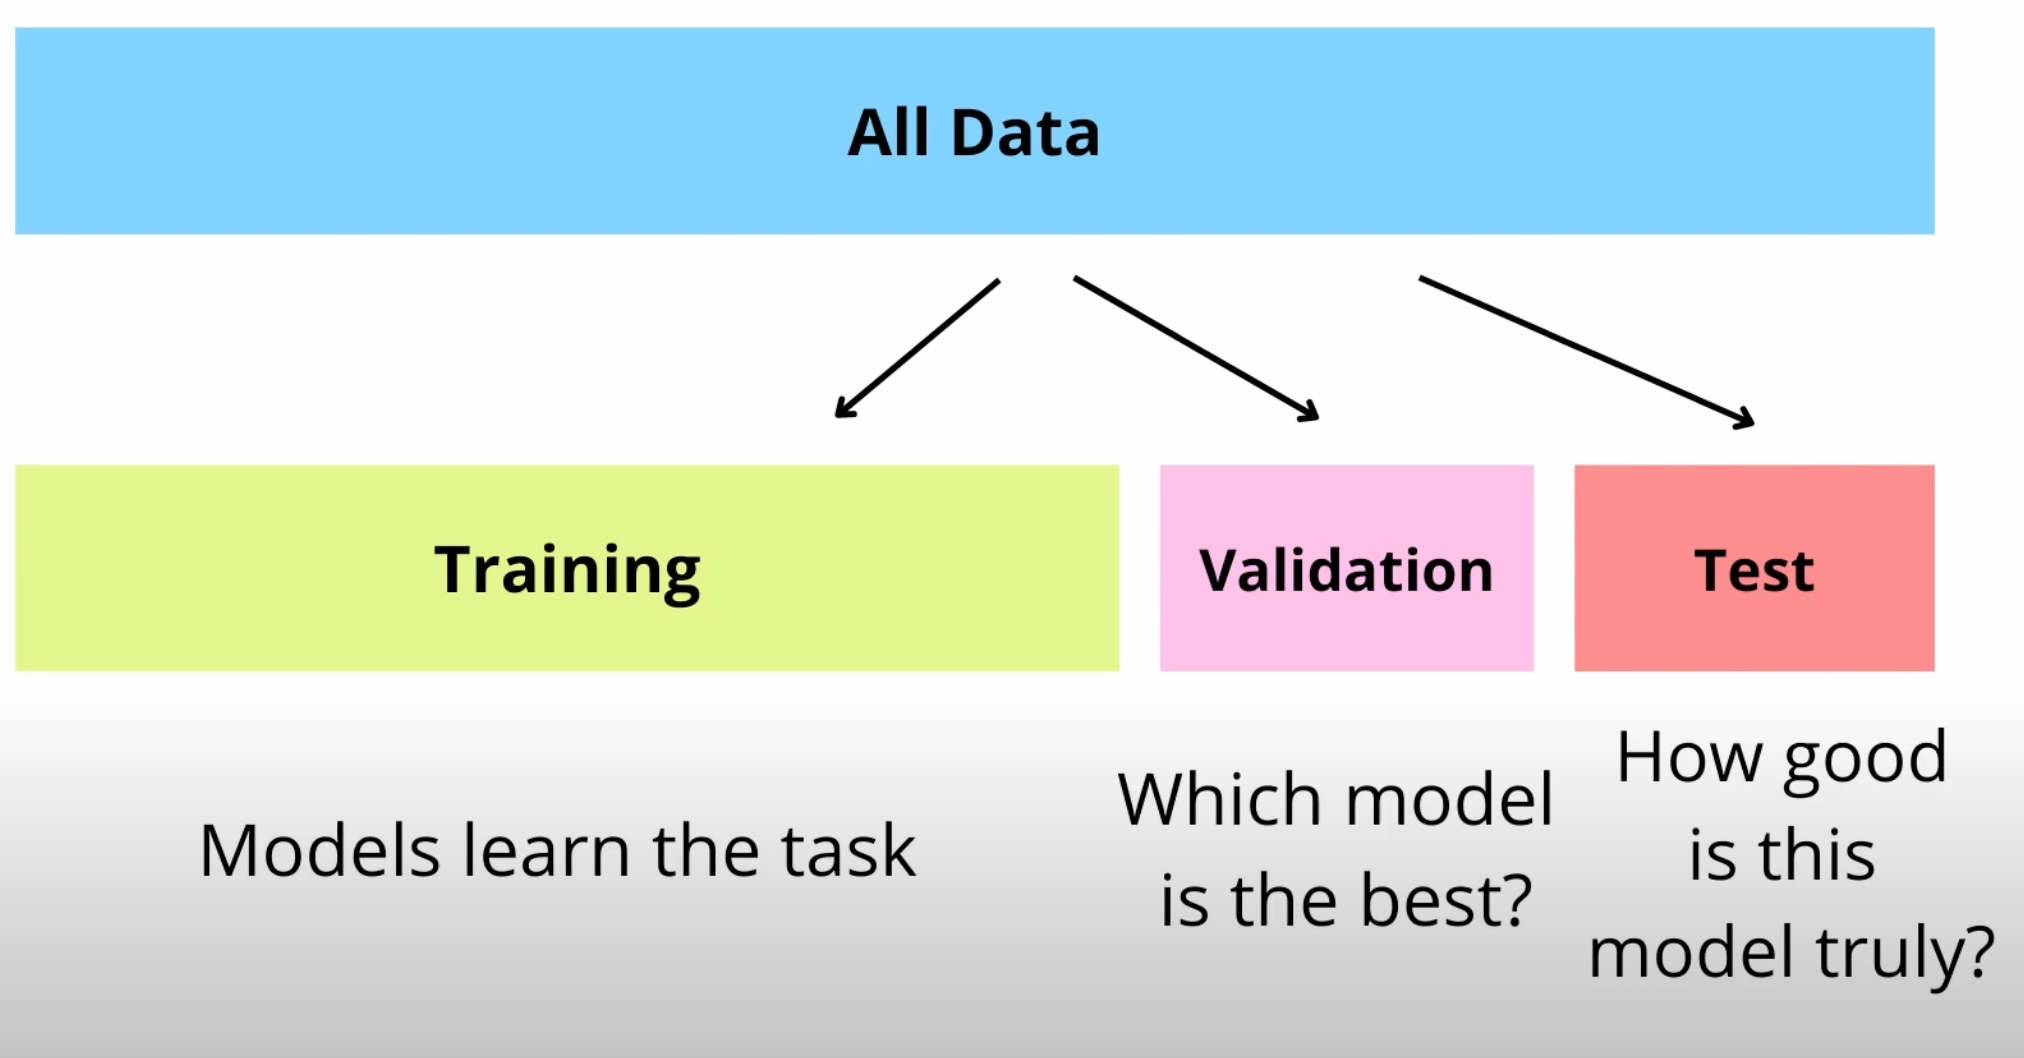 Screenshot taken from https://youtu.be/NPWlj9G1Si8. Learn more about train-validation-test split here: https://youtu.be/NPWlj9G1Si8

The rough standard for train-validation-test split is 60-80% goes to training, 10-20% goes to validation, and 10-20% goes to test.

In this notebook, you'll notice that for the data slicer, we've only split the dataset into `train` and `test`. Later in the next section, you'll split the training set into `train` and `validation`.

Finally, we are done working with the data. The next section will go over model creation for the HSNC class using cross-validation and hyperparameter grid search.

## **3.) Cross Validation and Hyperparameter Grid Search**

When performing the usual train/validation/test split for model training and testing, the model undergoes training on a specific randomly selected subset of the data, validation on another distinct set of data, and finally is tested on a separate holdout dataset. However, this approach can pose challenges, particularly with relatively small datasets, as it may exclude crucial observations essential for training an optimal model. Reserving a percentage of data outside the training phase, even if it's in the range of 15–25%, retains valuable information that can significantly enhance the effectiveness of our model training.

The solution is cross validation.

**Cross validation**: Entails dividing the dataset into random groups, reserving one group as the test set, and training the model on the remaining groups. This process is iterated for each group designated as the test set, and the resulting models are averaged to create the final model.

Here's a simple diagram of how it works:
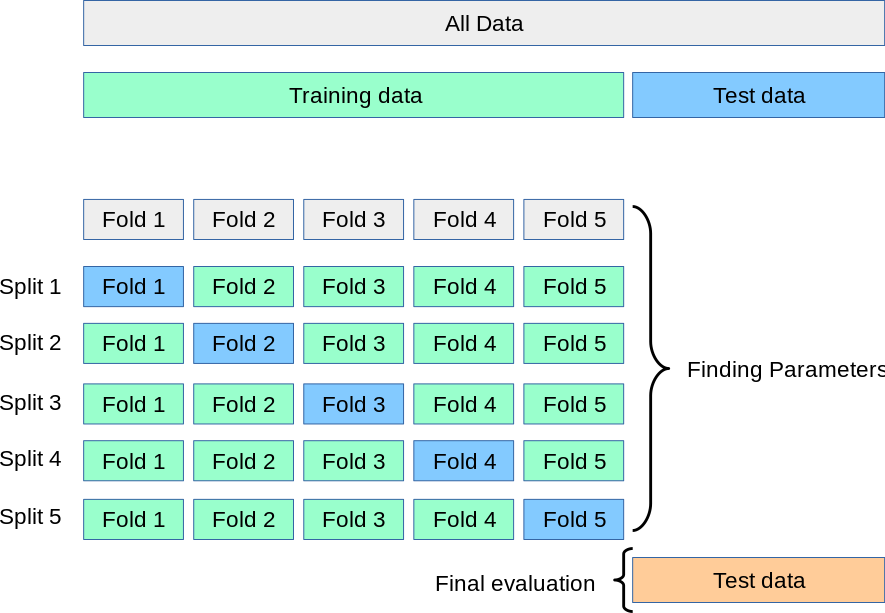
Image from scikit-learn website: https://scikit-learn.org/stable/modules/cross_validation.html

Read more how it works here: https://www.geeksforgeeks.org/cross-validation-machine-learning/

While cross validation can definitely benefit model development, one important drawback is that it is computationally expensive as the dataset gets larget and as the value of k increases. For the remainder of this section, we will look on how to implement cross validation on random forest. Additionally, we will run the model over a grid of hyperparmeters in order to identify optimal result.

**Hyperparameter Grid Search**: Systematically explores different hyperparameter combinations to find the best configuration for a model.


### **a) Training**

We will use HNSC vs All as an example first. For our classifier we will use Random Forest. For our cross validation object, we will use the library `StratifiedKFold` and set split to 5, shuffle to True, and declare the random state equal to our seed value.

**Validation set with StratifiedKFold**: In scikit-learn's StratifiedKFold, the dataset is divided into k folds, while ensuring each fold maintains the same class distribution as the original dataset. It takes care of creating the validation set and the truthful training sets using the training set we defined from the data slicer. The ratio of the validation set from the training set is `1/n_splits`.

Read more about `StratifiedKFold` here: https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedKFold.html



In [ ]:
features = exp1_datasets["HNSC"]["train"][0]
target = exp1_datasets["HNSC"]["train"][1]

rf = RandomForestClassifier(random_state=seed_value)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed_value)

Now let's create a grid of parameters values for our random forest classification model. The first parameter is n_estimators, which is the number of trees used in our random forest model. Read the rest of the definitions of the hyperparameters in sklearn's website: https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html

The next two cells are hyperparameter grids. The first `param_grid_orig` is the parameter grid that the paper used for hyperparameter fine-tuning.  Using this grid will take some time because of the many possible combinations. I recommend you use the second `param_grid`, a distilled version of the first one.

In [ ]:
# This grid is used in the paper (will run slower)
param_grid_orig = {
    'n_estimators': list(range(1, 401)),
    'criterion': ['gini', 'entropy'],  # Gini impurity or Shannon information gain
    'min_samples_split': list(range(2, 101)),
    'min_samples_leaf': list(range(1, 21)),
    'max_depth': list(range(1, 51)),  # Specify the range when max_depth is used
    'max_features': list(range(1, features.shape[1] + 1))  # 1 to maximum number of features
}

In [ ]:
# This grid is a distilled version of what's used in the paper (will run faster)
param_grid = {
    'n_estimators': list(range(1, 401, 50)), #skips every 50
    'criterion': ['gini', 'entropy'],  # Gini impurity or Shannon information gain
    'min_samples_split': list(range(2, 101,20)),
    'min_samples_leaf': list(range(1, 21,10)),
    'max_depth': list(range(1, 51,10)),  # Specify the range when max_depth is used
    'max_features': list(range(1, features.shape[1] + 1, 20))  # 1 to maximum number of features
}

**GridSearchCV:**
The module we will be utilizing is sklearn’s GridSearchCV, which will allow us to pass our specific estimator, our grid of parameters, our preferred scoring metric, and our cross validation object. The documentation for this method can be found here. The main parameters are highlighted below:

* **estimator**: this parameter allows you to select the specific model you’re choosing to run, in our case Random Forest Classification.
* **param_grid**: this parameter allows you to pass the grid of parameters you are searching. This grid must be formatted as a dictionary with the key corresponding to the specific estimator’s parameter names, and the values corresponding to a list of values to pass for the specific parameters.
* **scoring**: Strategy to evaluate the performance of the cross-validated model on the test set. For scoring, we will use `balanced_accuracy` as it is used in the paper. You can use other metrics as you wish.
* **n_jobs**: Number of jobs to run in parallel. `None` means 1 and `-1` means use all processors.
* **cv**: this parameter allows you to change the number of folds for the cross validation or a cross validation object.

In [ ]:
# Create the GridSearchCV object
grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    scoring=make_scorer(balanced_accuracy_score),  # Choose an appropriate metric for your problem
    cv=cv,
    n_jobs=6,  # Use all available processors,
    return_train_score=True
)

In [ ]:
# Perform the grid search
## Note: This code will run a while depending on big your parameter grid search is.
grid_search.fit(features, target)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=RandomForestClassifier(random_state=42), n_jobs=6,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [1, 11, 21, 31, 41],
                         'max_features': [1, 21, 41, 61, 81, 101, 121],
                         'min_samples_leaf': [1, 11],
                         'min_samples_split': [2, 22, 42, 62, 82],
                         'n_estimators': [1, 51, 101, 151, 201, 251, 301, 351]},
             return_train_score=True,
             scoring=make_scorer(balanced_accuracy_score))

In [ ]:
# Print the best hyperparameters
print("Best Hyperparameters:", grid_search.best_params_)

Best Hyperparameters: {'criterion': 'gini', 'max_depth': 21, 'max_features': 61, 'min_samples_leaf': 1, 'min_samples_split': 42, 'n_estimators': 51}


In [ ]:
# Get the best model
best_model = grid_search.best_estimator_

### **b.) Evaluation**

In [ ]:
# Access cv_results_ attribute to get detailed results
cv_results = grid_search.cv_results_

In [ ]:
# Get the test features and targets
test_features = exp1_datasets["HNSC"]["test"][0]
test_target = exp1_datasets["HNSC"]["test"][1]

# Check class distribution of the test set
print(test_target.value_counts())

label
0    54
1    23
Name: count, dtype: int64


**Balanced accuracy**: Balanced accuracy takes into account both sensitivity (true positive rate) and specificity (true negative rate) and provides a balanced view of the classifier's performance.

In [ ]:
# Get predictions
predictions = best_model.predict(test_features)

# Get classification report
class_report = classification_report(test_target, predictions)
print(class_report)

# Get the balanced accuracy
balanced_accuracy = balanced_accuracy_score(test_target, predictions)
print("Balanced Accuracy on Test Set:", balanced_accuracy)

# Create a confusion matrix
cm = confusion_matrix(test_target, predictions)
print(f"\nConfusion matrix for HNSC \n {c}")
print(f"\nTrue Positives: {cm[1, 1]}, True Negatives: {cm[0, 0]}, False Positives: {cm[0, 1]}, False Negatives: {cm[1, 0]}")

              precision    recall  f1-score   support

           0       0.87      0.89      0.88        54
           1       0.73      0.70      0.71        23

    accuracy                           0.83        77
   macro avg       0.80      0.79      0.80        77
weighted avg       0.83      0.83      0.83        77

Balanced Accuracy on Test Set: 0.7922705314009661

Confusion matrix for HNSC 
 [[48  6]
 [ 7 16]]

True Positives: 16, True Negatives: 48, False Positives: 6, False Negatives: 7


In [ ]:
# Calculate mean train score and mean validation score
# We have a mean train score and mean test score because our grid search did 5 splits, and the training and test scores of those splits need to be averaged.
mean_train_score = cv_results['mean_train_score'][grid_search.best_index_]
mean_validation_score = cv_results['mean_test_score'][grid_search.best_index_]

print("Mean Train Score:", mean_train_score)
print("Mean Validation Score:", mean_validation_score)

Mean Train Score: 0.9402205662678312
Mean Validation Score: 0.8451345102984448


In [ ]:
# Put everything in a report dictionary
report = {}
report["HNSC"] = {
    "model": best_model,
    "best_hyperparameters": grid_search.best_params_,
    "accuracy_on_test": balanced_accuracy,
    "mean_train_score": mean_train_score,
    "mean_test_score": mean_validation_score,
    "confusion_matrix": cm,
        }

**Observations and Analysis**:

This HNSC vs All model has a good balance between true positives and true negatives. A balanced accuracy on the test set of 0.79 is relatively high. The mean training score (0.94) is higher than the mean validation score (0.85), suggesting a possible overfitting, but the generalization to the test set is still reasonable. In summary, the model seems to perform well, but it's good to consider that this is only with one seed. In a professional research project, you would have to check for variance using different random seeds. I will provide the code below on how you can do this. For the sake of this project's simplicity, we would work with one seed value.

We have trained and evaluated a model for HNSC vs All using cross validation and grid search cross validation. Now, we need to perform the same steps for the rest of the classes.

## Task 1:

We have trained and evaluated a model for HNSC vs All using cross validation and grid search cross validation. For this task, pick another Targeted Class vs All binary classification to train and evaluate.

### a) Training:

In [ ]:
# Write your code for training here

### b) Evaluation:

In [ ]:
# Write your code for evaluation here

## **4.) Creating a Function to Go Over Each Class**

Now we've gone over how grid search cross validation, let's create a function that will work on all of our 5 OvA classes at once.

The input of this function are the following:
* **dataset_dict**: The dictionary of our datasets
* **classess**: A list of our classes
* **cv_n_split**: An integer that determines how many splits to use in cross validation. Default `5`.
* **n_jobs**: An integer that determines how many processes to use. Default `-1`, all processors.

The output is the following:
* **report**: A dictionary that includes the best model object, the best hyperparameters and evaluations, and the accuracy on the test set for each targeted label.

In [ ]:
def perform_gridsearchcv(dataset_dict, classes, seed=seed_value, cv_n_splits=5, n_jobs=-1):
    """
    This function will perform GridSearchCV for each class.

    inputs:
    dataset_dict (dict): datasets from data_slicer()
    classes (list): class names
    seed (int): introduce randomness
    cv_n_split (int): determines how many splits to use in cross validation. Default `5`.
    n_jobs (int): determines how many processes to use. Default `-1`, all processors.

    output:
    report (dict): holds the best model object, the best hyperparameters, and evaluation scores for each targeted label.
    """

    report = {}

    print("Random Seed: ", seed)

    for c in classes:

        print("Class: ", c)
        train_features = dataset_dict[c]["train"][0]
        train_target = dataset_dict[c]["train"][1]
        test_features = dataset_dict[c]["test"][0]
        test_target = dataset_dict[c]["test"][1]

        # Define the classifier
        rf = RandomForestClassifier(random_state=seed)

        # Define the hyperparameters and their values for the grid search
        param_grid = {
            'n_estimators': list(range(1, 401, 50)),
            'criterion': ['gini', 'entropy'],  # Gini impurity or Shannon information gain
            'min_samples_split': list(range(2, 101,20)),
            'min_samples_leaf': list(range(1, 21,10)),
            'max_depth': list(range(1, 51,10)),  # Specify the range when max_depth is used
            'max_features': list(range(1, train_features.shape[1] + 1, 20))  # 1 to maximum number of features
        }

        # Create a cross validation object
        cv = StratifiedKFold(n_splits=cv_n_splits, shuffle=True, random_state=seed)

        # Create the GridSearchCV object
        grid_search = GridSearchCV(
            estimator=rf,
            param_grid=param_grid,
            scoring=make_scorer(balanced_accuracy_score),  # Choose an appropriate metric for your problem
            cv=cv,
            n_jobs=n_jobs,  # Use all available processors,
            return_train_score=True
        )

        # Perform the grid search
        grid_search.fit(train_features, train_target)

        # Access cv_results_ attribute to get detailed results
        cv_results = grid_search.cv_results_

        # Print the best hyperparameters
        print("Best Hyperparameters:", grid_search.best_params_)

        # Get the best model
        best_model = grid_search.best_estimator_

        # Evaluate the best model on test set
        predictions = best_model.predict(test_features)

        # Get classification report
        class_report = classification_report(test_target, predictions)
        # print(class_report)

        # Get the balanced accuracy
        balanced_accuracy = balanced_accuracy_score(test_target, predictions)
        print("Test Score:", balanced_accuracy)

        # Create a confusion matrix
        cm = confusion_matrix(test_target, predictions)
        # print(f"\nConfusion matrix for {c}\n")
        print(f"True Positives: {cm[1, 1]}, True Negatives: {cm[0, 0]}, False Positives: {cm[0, 1]}, False Negatives: {cm[1, 0]}")

        # Calculate mean train score and mean test score
        mean_train_score = cv_results['mean_train_score'][grid_search.best_index_]
        mean_test_score = cv_results['mean_test_score'][grid_search.best_index_]

        print("Mean Train Score:", mean_train_score)
        print("Mean Validation Score:", mean_test_score)


        report[c] = {
            "model": best_model,
            "best_hyperparameters": grid_search.best_params_,
            "test_score": balanced_accuracy,
            "mean_train_score": mean_train_score,
            "mean_validation_score": mean_test_score,
            "confusion_matrix": cm,
            "classification_report": class_report,
        }

    return report

In [ ]:
# Run the perform_gridsearchcv with just one seed (will run faster)
exp1_report = perform_gridsearchcv(exp1_datasets, classes, seed=seed_value)

Random Seed:  42
Class:  HNSC


Best Hyperparameters: {'criterion': 'gini', 'max_depth': 21, 'max_features': 61, 'min_samples_leaf': 1, 'min_samples_split': 42, 'n_estimators': 51}
Test Score: 0.7922705314009661
True Positives: 16, True Negatives: 48, False Positives: 6, False Negatives: 7
Mean Train Score: 0.9402205662678312
Mean Validation Score: 0.8451345102984448
Class:  STAD
Best Hyperparameters: {'criterion': 'gini', 'max_depth': 11, 'max_features': 101, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 101}
Test Score: 0.7722323049001816
True Positives: 11, True Negatives: 56, False Positives: 2, False Negatives: 8
Mean Train Score: 0.9746057203956162
Mean Validation Score: 0.8339194139194139
Class:  COAD
Best Hyperparameters: {'criterion': 'gini', 'max_depth': 11, 'max_features': 61, 'min_samples_leaf': 1, 'min_samples_split': 42, 'n_estimators': 101}
Test Score: 0.9219600725952812
True Positives: 18, True Negatives: 52, False Positives: 6, False Negatives: 1
Mean Train Score: 0.9522089274700546


/Users/gbaldonado/miniforge3/envs/ml_env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/gbaldonado/miniforge3/envs/ml_env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/gbaldonado/miniforge3/envs/ml_env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, m

**Checking for result variance**: The code in this block will run the `perform_gridsearchcv()` for 5 seeds to check for variance of the report. You don't need to run this, but keep in mind that checking statistical variance makes sure that

```python
# Run the perform_gridsearchcv with 5 seeds for variance (will run slower)
random_seeds = [959, 699, 663, 73, 623]

# Note: This optional cell will run for a long time depending on your computational resources.
all_reports = []
for s in random_seeds:
    report = perform_gridsearchcv(exp1_datasets, classes, seed=s)
    all_reports.append(report)

```


It's good practice to export the findings of the experiment so that you can go back later and perform any analysis.

In [ ]:
def best_hyperparameter_to_df(nested_dict, exp_name):
    """
    Saves the best hyperparameters

    nested_dict (dict): the report
    exp_name (str): name of the experiment

    output:
    df (Dataframe): the table of the best hyperparameters and metrics
    """
    path = "./dataset/microbiome_preprocessed_files/"
    data = []

    for key, value in nested_dict.items():
        entry = {'label': key}
        entry.update(value['best_hyperparameters'])
        entry['test_score'] = value['test_score']
        entry['mean_train_score'] = value['mean_train_score']
        entry['mean_validation_score'] = value['mean_validation_score']
        data.append(entry)

    df = pd.DataFrame(data)

    df.to_csv(path+f"{exp_name}_best_hyperparam.csv", index=False)
    return df

In [ ]:
best_hyperparameter_to_df(exp1_report, "exp1")

,label,criterion,max_depth,max_features,min_samples_leaf,min_samples_split,n_estimators,test_score,mean_train_score,mean_validation_score
0,HNSC,gini,21,61,1,42,51,0.792271,0.940221,0.845135
1,STAD,gini,11,101,1,2,101,0.772232,0.974606,0.833919
2,COAD,gini,11,61,1,42,101,0.921960,0.952209,0.924366
3,ESCA,entropy,11,81,1,22,1,0.526144,0.787640,0.716555
4,READ,gini,11,61,1,2,1,0.500000,0.827371,0.677520


## **5.) Results and Discussion**

| Classification | Paper Test Accuracy | Experiment 1 Test Accuracy |
|----------------|---------------------|----------------------------|
| HNSC vs All    | 80.78               | 79.29                      |
| STAD vs All    | 82.84               | 77.22                      |
| COAD vs All    | 93.54               | 92.20                      |
| ESCA vs All    | 61.37               | 52.61                      |
| READ vs All    | 56.43               | 50.00                      |


The table above highlights variations in test accuracy between the paper's reported results and this notebook's experiment 1 for each cancer type or class. It is clear there is a decrease in test accuracy across all classes, but this difference is expected given that for we used a distilled version of the hyperparameter grid when training our models. The magnitude of the difference in test accuracy varies, with some cancer types experiencing only minor deviations, while others more substantial difference.
1. HNSC vs All, COAD vs All:
* These are the top performers. The difference between experiment and paper (-1.49, -1.34) is relatively small, suggesting that the model's performance is reasonably consistent between the experiment and paper. Their top performance can be attributed to higher class distributions based on our exploratory data analysis (EDA) from notebook 1.
2. STAD vs All:
* The difference (-5.62) is noticeable. This is an interesting result because it is unexpected, given that STAD has the second highest class distribution based on our EDA.
3. ESCA vs All and READ vs All:
* The differences (-8.76, -6.43) are significant, and this can be attributed to the lower counts of samples belonging to ESCA and READ based on our EDA. In the first notebook, we hypothesized that ESCA and READ will perform the worst. After running the experiments, our hypothesis turns out to be correct!

## Task 2:

Look back into the class distribution from our EDA in notebook 1. Discuss how the class distribution could play into effect on how the models performed.

**Your answer**:

## Task 3:

For extra practice, try removing or adding new hyperparameter values in the `param_grid` and rerun the experiment.

In [ ]:
# Write your code here

**Exporting**

In [ ]:
## Export the results to colab
import json

path = "/content/drive/MyDrive/microbiome_dataset/microbiome_preprocessed_files/"
os.makedirs(path, exist_ok=True)

with open(path + "exp1_report.txt", "w") as file:
    json.dump(str(exp1_report), file, indent=4)

In [ ]:
## Export the results
import json

path = "./dataset/microbiome_preprocessed_files/"
os.makedirs(path, exist_ok=True)

with open(path + "exp1_report.txt", "w") as file:
    json.dump(str(exp1_report), file, indent=4)

Thanks for making it this far! We have accomplished experiment 1, which will serve as our baseline for our other experiments. In experiment 2, we will explore if we can improve our performance by adding additional features using feature engineering.